<a href="https://colab.research.google.com/github/PeraHive/project-redspot/blob/main/Test%20Simulations/Visual_Odometry_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project Redspot – PeraHive  
## Visual Odometry Simulator (Notebook Template)

**Faculty of Engineering, University of Peradeniya**  
**Topic:** Drone Localization using **Visual Odometry (VO)** (instead of Particle Filtering)

---

### What this notebook does
This notebook simulates a drone moving on a **planar trajectory** and estimates its motion using a **feature-based Visual Odometry pipeline**:

- Generate a synthetic “textured” scene (random dots)
- Render camera frames along a known trajectory
- Detect & match features between consecutive frames (ORB)
- Estimate frame-to-frame motion (2D transform) using RANSAC
- Integrate relative motion to get an estimated trajectory
- Visualize ground-truth vs VO trajectory and error

> This is a **simulation template** designed to mirror the layout of your existing `Simulator.ipynb`,
> but using **Visual Odometry** instead of a **Particle Filter**.



## 0. Setup

We will use:
- `numpy` for math
- `matplotlib` for plots
- `opencv-python (cv2)` for ORB feature extraction + matching + RANSAC motion estimation

If OpenCV is not available in your environment, install it via:
```bash
pip install opencv-python
```


In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Optional: OpenCV for feature-based VO
try:
    import cv2
    OPENCV_OK = True
    print("OpenCV detected:", cv2.__version__)
except Exception as e:
    OPENCV_OK = False
    print("OpenCV not available. Error:", e)

np.random.seed(42)


OpenCV detected: 4.12.0



## 1. Background Theory

### 1.1 Visual Odometry (VO)
Visual Odometry estimates the **relative motion** of a camera by analyzing **consecutive frames**:

- Detect visual features (corners/keypoints)
- Match features between frame *t* and frame *t+1*
- Estimate the camera motion that best explains the feature displacement
- Integrate (accumulate) motion over time to form a trajectory

### 1.2 Key difference from Particle Filter localization
- Particle Filter + beacons: provides **absolute/global position** using a map & measurements
- VO: provides **relative motion** (Δx, Δy, Δθ) and will **drift** over time unless corrected by landmarks, loop closure, or other sensors.

### 1.3 What we estimate here
To keep the simulator simple (and aligned with a 2D flight path), we estimate a **2D rigid transform** between frames:
- Translation: Δx, Δy
- Rotation: Δθ

We do this using a robust estimator (RANSAC) over feature matches.



## 2. Simulation Design

### 2.1 Synthetic scene
We create a grayscale image with many random dots. This acts as a “textured floor / environment” so VO can track features.

### 2.2 Camera frames along a trajectory
We simulate a moving camera by applying:
- a rotation
- a translation (pixel shift)

to the base texture.  
This gives us a sequence of frames with known ground-truth motion.

### 2.3 VO pipeline (feature-based)
For each consecutive pair of frames:
1. Detect ORB keypoints + descriptors
2. Match descriptors (Hamming distance)
3. Estimate 2D transform using RANSAC
4. Convert that transform into Δx, Δy, Δθ
5. Integrate to build the estimated trajectory


In [2]:

def make_textured_scene(h=480, w=640, n_dots=2500, dot_radius=1):
    """Create a synthetic textured grayscale scene (random dots)."""
    if not OPENCV_OK:
        raise RuntimeError("OpenCV is required. Install with: pip install opencv-python")
    img = np.zeros((h, w), dtype=np.uint8)
    ys = np.random.randint(0, h, size=n_dots)
    xs = np.random.randint(0, w, size=n_dots)
    for x, y in zip(xs, ys):
        cv2.circle(img, (int(x), int(y)), dot_radius, 255, -1)
    # Slight blur to create more stable features
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img

def warp_frame(base_img, dx_px, dy_px, dtheta_deg):
    """Warp base image by rotation + translation (simulated camera motion)."""
    h, w = base_img.shape
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, dtheta_deg, 1.0)  # 2x3
    M[:, 2] += [dx_px, dy_px]
    warped = cv2.warpAffine(
        base_img, M, (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )
    return warped, M

if not OPENCV_OK:
    raise RuntimeError("OpenCV is required for this notebook. Install with: pip install opencv-python")



## 3. Ground-truth Trajectory

We define a smooth 2D path (x, y, θ) in **world units**.

Then we map those motions to **pixel transforms** to generate frames.

> In a real drone, pixels ↔ meters depends on camera intrinsics and scene depth.
> Here we use a simple scale factor for demonstration.


In [3]:

def generate_trajectory(num_steps=200):
    """Create a smooth planar trajectory. Returns x, y, theta (radians)."""
    t = np.linspace(0, 2*np.pi, num_steps)
    x = 2.5*np.cos(t) + 0.5*np.cos(3*t)
    y = 2.0*np.sin(t) + 0.3*np.sin(2*t)
    theta = 0.25*np.sin(1.5*t)  # small yaw oscillation
    return x, y, theta

num_steps = 220
x_gt, y_gt, th_gt = generate_trajectory(num_steps)

# Map world units to pixel motion (tunable)
PX_PER_UNIT = 18.0
DEG_PER_RAD = 180/np.pi

dx_gt = np.diff(x_gt) * PX_PER_UNIT
dy_gt = np.diff(y_gt) * PX_PER_UNIT
dth_gt = np.diff(th_gt) * DEG_PER_RAD  # degrees

dx_gt[:5], dy_gt[:5], dth_gt[:5]


(array([-0.05183571, -0.15524523, -0.25787087, -0.35919615, -0.45871375]),
 array([1.3423964 , 1.34052702, 1.33679232, 1.3312004 , 1.32376337]),
 array([0.61624809, 0.61510694, 0.61282676, 0.60941176, 0.60486827]))


## 4. Generate Synthetic Camera Frames

We generate frames by applying the *cumulative* transform of the trajectory to the base texture.


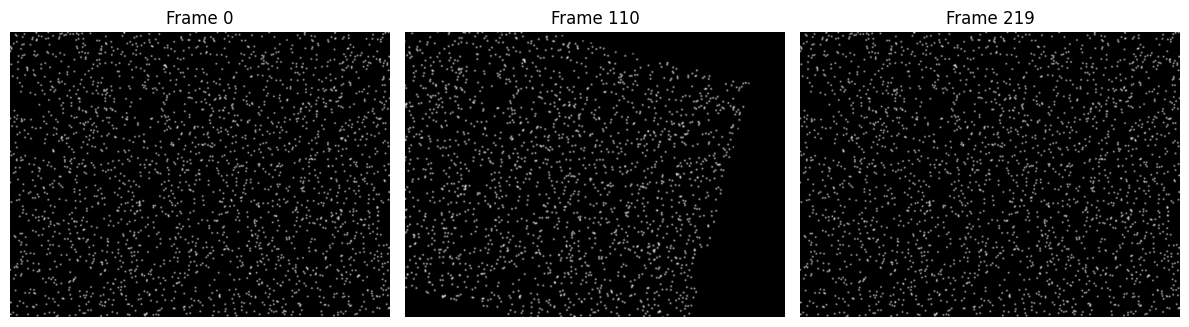

In [4]:

base = make_textured_scene()

frames = []
true_pose_px = [(0.0, 0.0, 0.0)]  # (x_px, y_px, theta_deg)

x_px, y_px, th_deg = 0.0, 0.0, 0.0
frames.append(base.copy())

for i in range(num_steps - 1):
    x_px += dx_gt[i]
    y_px += dy_gt[i]
    th_deg += dth_gt[i]
    true_pose_px.append((x_px, y_px, th_deg))
    f, _ = warp_frame(base, x_px, y_px, th_deg)
    frames.append(f)

# Show a few frames
fig = plt.figure(figsize=(12, 4))
for idx, k in enumerate([0, (num_steps//2), num_steps-1]):
    ax = fig.add_subplot(1, 3, idx+1)
    ax.imshow(frames[k], cmap='gray')
    ax.set_title(f"Frame {k}")
    ax.axis('off')
plt.tight_layout()
plt.show()



## 5. Visual Odometry Implementation (ORB + Matching + RANSAC)

We estimate motion between consecutive frames using:
- ORB features + binary descriptors
- BFMatcher with Hamming distance
- RANSAC to fit a 2D transform robustly (reject outliers)

We extract:
- Δx, Δy from translation
- Δθ from rotation

and integrate them to form the estimated trajectory.


In [5]:

def estimate_motion_2d(frame_a, frame_b, max_features=1500):
    """
    Estimate 2D motion between two frames using ORB + BFMatcher + RANSAC.
    Returns: (success, dx, dy, dtheta_deg, inliers_ratio)
    """
    orb = cv2.ORB_create(nfeatures=max_features)
    kpa, desa = orb.detectAndCompute(frame_a, None)
    kpb, desb = orb.detectAndCompute(frame_b, None)

    if desa is None or desb is None or len(kpa) < 10 or len(kpb) < 10:
        return False, 0.0, 0.0, 0.0, 0.0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desa, desb)
    if len(matches) < 12:
        return False, 0.0, 0.0, 0.0, 0.0

    matches = sorted(matches, key=lambda m: m.distance)
    keep = matches[: min(400, len(matches))]

    pts_a = np.float32([kpa[m.queryIdx].pt for m in keep]).reshape(-1, 1, 2)
    pts_b = np.float32([kpb[m.trainIdx].pt for m in keep]).reshape(-1, 1, 2)

    M, inliers = cv2.estimateAffinePartial2D(
        pts_a, pts_b,
        method=cv2.RANSAC,
        ransacReprojThreshold=3.0
    )
    if M is None or inliers is None:
        return False, 0.0, 0.0, 0.0, 0.0

    inliers_ratio = float(inliers.sum()) / float(len(inliers))

    a, b, tx = M[0]
    c, d, ty = M[1]
    dtheta = np.degrees(np.arctan2(c, a))

    return True, float(tx), float(ty), float(dtheta), inliers_ratio


# Run VO over all frames
dx_est, dy_est, dth_est, inlier_ratios = [], [], [], []

for i in range(num_steps - 1):
    ok, tx, ty, dtheta, r = estimate_motion_2d(frames[i], frames[i+1])
    dx_est.append(tx)
    dy_est.append(ty)
    dth_est.append(dtheta)
    inlier_ratios.append(r if ok else 0.0)

dx_est = np.array(dx_est)
dy_est = np.array(dy_est)
dth_est = np.array(dth_est)
inlier_ratios = np.array(inlier_ratios)

dx_est[:5], dy_est[:5], dth_est[:5], inlier_ratios.mean()


(array([-2.50720465, -2.69223706, -2.66959401, -2.99627408, -2.95090243]),
 array([4.81790051, 4.7129855 , 4.79758515, 4.58918124, 4.69701581]),
 array([-0.61009588, -0.60788897, -0.6058471 , -0.59817384, -0.59666025]),
 np.float64(0.995365296803653))


## 6. Integrate Estimated Motion to Reconstruct Trajectory

We integrate:
- x(t+1) = x(t) + Δx(t)
- y(t+1) = y(t) + Δy(t)
- θ(t+1) = θ(t) + Δθ(t)

This produces the VO trajectory in the same **pixel-coordinate** space as the ground truth.


In [6]:

x_vo = [0.0]
y_vo = [0.0]
th_vo = [0.0]

for i in range(num_steps - 1):
    x_vo.append(x_vo[-1] + dx_est[i])
    y_vo.append(y_vo[-1] + dy_est[i])
    th_vo.append(th_vo[-1] + dth_est[i])

x_vo = np.array(x_vo)
y_vo = np.array(y_vo)
th_vo = np.array(th_vo)

x_true = np.array([p[0] for p in true_pose_px])
y_true = np.array([p[1] for p in true_pose_px])
th_true = np.array([p[2] for p in true_pose_px])

pos_err = np.sqrt((x_vo - x_true)**2 + (y_vo - y_true)**2)

pos_err[:5], pos_err[-1]


(array([ 0.        ,  4.25534552,  8.47456535, 12.69215888, 16.87842599]),
 np.float64(19.52327277601626))


## 7. Results Visualization

We plot:
- Ground-truth trajectory vs VO-estimated trajectory
- Position error over time
- Inlier ratio (match quality)


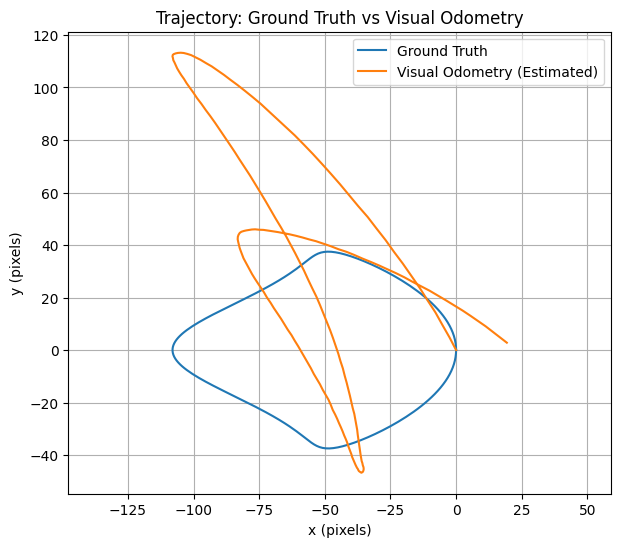

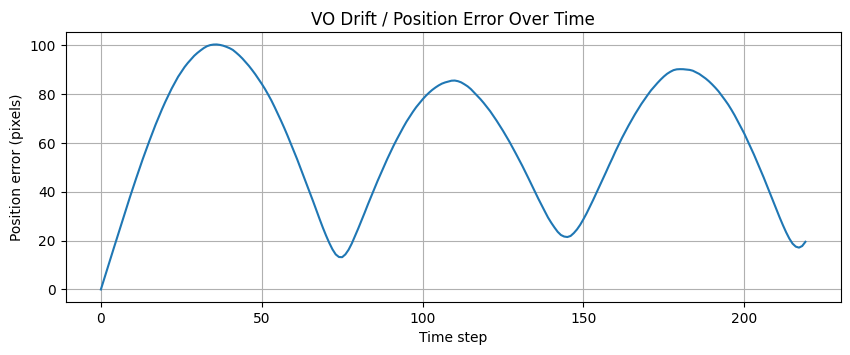

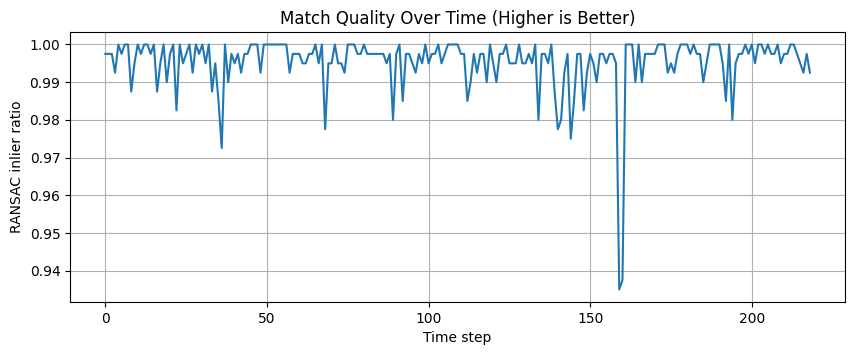

In [7]:

plt.figure(figsize=(7, 6))
plt.plot(x_true, y_true, label="Ground Truth")
plt.plot(x_vo, y_vo, label="Visual Odometry (Estimated)")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.title("Trajectory: Ground Truth vs Visual Odometry")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 3.5))
plt.plot(pos_err)
plt.xlabel("Time step")
plt.ylabel("Position error (pixels)")
plt.title("VO Drift / Position Error Over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3.5))
plt.plot(inlier_ratios)
plt.xlabel("Time step")
plt.ylabel("RANSAC inlier ratio")
plt.title("Match Quality Over Time (Higher is Better)")
plt.grid(True)
plt.show()



## 8. Discussion

### 8.1 Why drift happens
VO integrates small errors at every step, so even tiny biases accumulate into a large final error.

### 8.2 How to improve realism and accuracy
To make this closer to a real drone system:
- Use camera intrinsics + 3D geometry (Essential matrix / PnP)
- Add IMU fusion (Visual-Inertial Odometry, VIO)
- Add loop closure (Visual SLAM)
- Or keep IR beacons as occasional global corrections (best for GPS-denied)

### 8.3 Linking back to your IR beacon project
A strong final design often is:
- VO/VIO for continuous motion
- IR beacons for periodic absolute pose correction
- Fuse in an EKF or pose-graph optimization



## 9. Optional Extensions (Good for Phase 2)

- Add noise (motion blur, lighting changes, dropped frames)
- Compare ORB with other detectors (FAST+BRIEF, SIFT if available)
- Use optical flow (Lucas–Kanade) instead of descriptor matching
- Add a beacon-correction step to demonstrate drift reset


In [8]:
# End of notebook.